# Week 3 Notebook

## Initialisation <a id='init'></a>

In [87]:
# import packages
import pandas as pd
import numpy as np

# set working directory
import os
os.chdir('/home/jovyan/work/')

In [88]:
from src.data.load_dataset import load_split_store
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()

# load_split_store
X_train, y_train, X_val, y_val, X_test, y_test, test_data = load_split_store(
                                                                    filepath='data/', 
                                                                    scaler=scaler, 
                                                                    resample=False, 
                                                                    random_state=42, 
                                                                    test_size=0.1,
                                                                    replace_negatives=False)

## Load base from Week 2 <a id='base'></a>

In [89]:
from joblib import load

week2_model = load(open('models/david_0214_xgb_hyperopt.joblib', 'rb'))

-----------
Confusion Matrix with thresthold of 0.5:


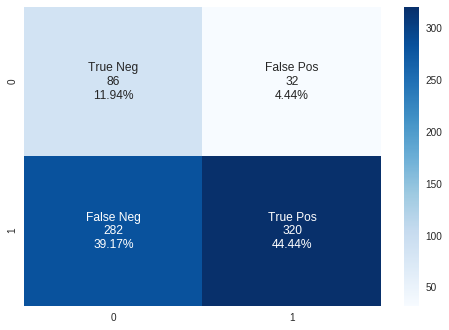

352 out of 720 or 49% of players are predicted to be 5+ Yrs
-----------
Recall: 0.5316
Accuracy: 0.5639
F1: 0.6709
-----------
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.699


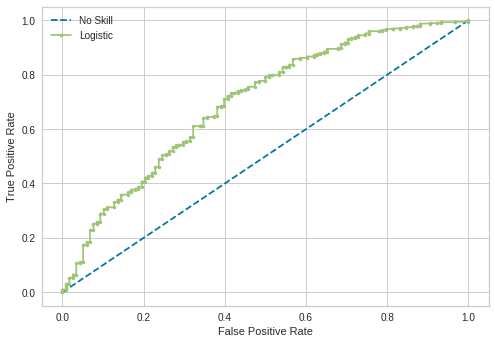

In [90]:
from src.visualization.visualize import eval_metrics

y_val_pred = week2_model.predict_proba(X_val)[:, 1]
eval_metrics(y_val_pred, y_val, praba_threshold=0.5)

## Week 3 Experiement 

### Add new cluster feature <a id='cluster'></a>

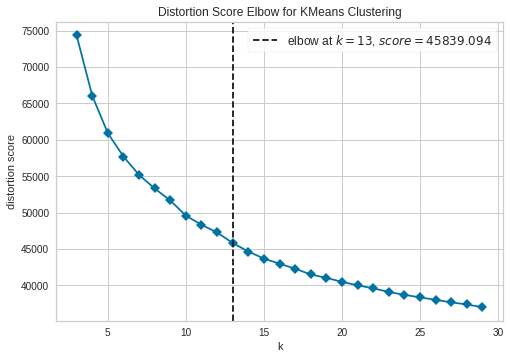

In [95]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

# initialise KMeans model with Elbow visualiser
model = KMeans()
visualizer = KElbowVisualizer(model, k=(3,30), timings=False)

# fit and identify elbow point
visualizer.fit(X_train)
visualizer.show()

In [97]:
from sklearn.mixture import GaussianMixture

nc = visualizer.elbow_value_

clr_model = GaussianMixture(nc, random_state=42)

clr_model.fit(X_train)

obs_train = clr_model.predict(X_train)
obs_val = clr_model.predict(X_val)
obs_test = clr_model.predict(test_data)

In [98]:
X_train_clr = X_train.copy()
X_train_clr['cluster_group'] = obs_train

X_val_clr = X_val.copy()
X_val_clr['cluster_group'] = obs_val

test_clr = test_data.copy()
test_clr['cluster_group'] = obs_test

In [99]:
clr_comp_train = X_train_clr.groupby('cluster_group').agg(
                                                count=('Target', 'count'),
                                                tot_5yr=('Target', 'sum')
                                                )

clr_comp_train['pct_5yr'] = clr_comp_train['tot_5yr'] / clr_comp_train['count']

clr_comp_train

KeyError: "Column 'Target' does not exist!"

In [27]:
len(clr_comp_train)

7

In [33]:
len(clr_comp_train)
clr_comp_train.iloc[0]['pct_5yr']

0.8414096916299559

In [8]:
from src.features.build_features import add_features_min_average

X_train_nf = add_features_min_average(X_train_clr)
X_train_nf['Target'] = y_train

X_val_nf = add_features_min_average(X_val_clr)
X_val_nf['Target'] = y_val

test_nf = add_features_min_average(test_clr)

In [9]:
week2_model.get_xgb_params()

{'objective': 'binary:logistic',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0.6,
 'gpu_id': -1,
 'interaction_constraints': '',
 'learning_rate': 0.04,
 'max_delta_step': 0,
 'max_depth': 7,
 'min_child_weight': 23.0,
 'monotone_constraints': '()',
 'n_jobs': 3,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 0.19966791199667913,
 'subsample': 0.30000000000000004,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None,
 'eval_metric': 'logloss'}

In [35]:
param = week2_model.get_xgb_params()
param.pop('scale_pos_weight')
param

{'objective': 'binary:logistic',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0.6,
 'gpu_id': -1,
 'interaction_constraints': '',
 'learning_rate': 0.04,
 'max_delta_step': 0,
 'max_depth': 7,
 'min_child_weight': 23.0,
 'monotone_constraints': '()',
 'n_jobs': 3,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'subsample': 0.30000000000000004,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None,
 'eval_metric': 'logloss'}

In [10]:
X_train_nf

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,...,TOV,cluster_group,PTS_pm,FTM_pm,REB_pm,AST_pm,STL_pm,BLK_pm,TOV_pm,Target
7629,-0.337538,-0.769658,-1.034416,-0.949075,-0.957280,-0.310135,-0.688743,-0.581170,0.888399,-1.179712,...,-1.186024,3,1.343996,1.532775,1.212210,0.598433,1.111486,0.388070,1.540976,1
6200,-0.746471,0.976343,0.980190,0.822648,1.246755,-1.252448,0.352736,0.549947,0.688426,1.735756,...,1.302827,1,1.003940,1.777814,0.321609,0.510254,1.385353,0.442619,1.334395,1
1201,-0.863309,-0.959927,-0.316568,-0.299443,-0.148204,-1.089980,-0.428374,-0.392651,1.357086,-0.531830,...,-0.771215,2,0.329784,0.554032,0.672156,0.787138,-0.131145,0.057370,0.803411,1
3219,0.889262,1.166612,0.169716,0.468303,0.102889,1.899427,-1.730223,-1.806547,-1.461284,0.008072,...,-0.079868,0,0.145478,0.006919,3.064732,0.110941,0.528509,1.727747,-0.068461,1
4320,-1.447500,0.069766,-0.223943,-0.299443,-0.622490,1.915673,-1.469853,-1.523768,-1.242564,1.411815,...,0.334941,4,-3.209915,20.236475,42.998404,-15.058967,-5.228734,4.448357,4.800923,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1206,0.363491,-0.780850,-0.872322,-0.830960,-0.789885,-0.488849,0.352736,0.644207,1.019631,-1.071732,...,-0.909485,5,1.117144,1.372519,1.256257,-0.260199,-0.475415,2.410378,1.164737,1
2106,0.363491,0.416728,0.053934,0.350188,0.298183,0.339736,0.873476,1.021246,0.932143,-0.747791,...,-0.356407,2,0.129423,-1.794435,-0.742674,-0.043382,0.890815,-0.424440,-0.855252,1
3156,-1.681176,-0.702504,-0.548132,-0.830960,-0.901482,0.307243,1.394215,1.021246,0.857153,0.655953,...,-0.909485,2,0.780255,-0.933737,0.918458,1.600495,1.217735,-0.094994,1.294634,1
2935,-0.863309,-0.971119,-0.964947,-1.008132,-1.096776,0.047294,-1.730223,-1.712288,-0.417675,0.008072,...,-0.218137,2,0.993644,-0.008312,0.664409,0.929957,0.880905,0.182136,0.224625,1


In [79]:
from joblib import dump
import xgboost as xgb

clusters = np.unique(obs_train)

dump(clr_model, 'models/david_w3_gmm.joblib')

for grp in clusters:
    df = X_train_nf[X_train_nf['cluster_group']==grp]
    target = df.pop('Target')
    print(f'training group {grp}')
    param = week2_model.get_xgb_params()
    w = 1-clr_comp_train.iloc[grp]['pct_5yr']
    param['scale_pos_weight'] = w
    param['gamma'] = 0.8
    xgb_hpr = xgb.XGBClassifier(scale_pos_weight=w, use_label_encoder=False).fit(df, target)
    dump(xgb_hpr, 'models/david_w3_split_grp_'+str(grp)+'.joblib')

training group 0
[07:14:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
training group 1
[07:14:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
training group 2
[07:14:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
training group 3
[07:14:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logl

In [80]:
df_val_cluster = X_val_nf

dfc = pd.DataFrame()

for grp in clusters:
    print(f'predicting group {grp}')
    df = df_val_cluster[df_val_cluster['cluster_group']==grp]
    df1 = df.copy()
    y = df1.pop('Target')
    xgboost = load(open('models/david_w3_split_grp_'+str(grp)+'.joblib', 'rb'))
    df['Pred_5Yrs'] = xgboost.predict_proba(df1)[:,1]
    dfc = dfc.append(df)

predicting group 0
predicting group 1
predicting group 2
predicting group 3
predicting group 4
predicting group 5


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


predicting group 6


In [82]:
clr_comp_val = dfc.groupby('cluster_group').agg(
                                                count=('Target', 'count'),
                                                tot_5yr=('Target', 'sum')
                                                )

clr_comp_val['pct_5yr'] = clr_comp_val['tot_5yr'] / clr_comp_val['count']

clr_comp_val

,count,tot_5yr,pct_5yr
cluster_group,,,
0,40,36,0.900000
1,170,144,0.847059
2,329,275,0.835866
3,173,114,0.658960
4,201,182,0.905473
5,73,54,0.739726
6,34,31,0.911765


In [83]:
from sklearn.metrics import roc_auc_score, accuracy_score

auc_scores = []
acc_scores = []

for grp in clusters:
    df = dfc[dfc['cluster_group']==grp]
    auc = roc_auc_score(df.Target, df.Pred_5Yrs)
    auc_scores.append(auc)
    acc = accuracy_score(df.Target, round(df.Pred_5Yrs, 0))
    acc_scores.append(acc)
    
clr_comp_val['auc_score'] = auc_scores
clr_comp_val['accuracy_score'] = acc_scores

clr_comp_val

,count,tot_5yr,pct_5yr,auc_score,accuracy_score
cluster_group,,,,,
0,40,36,0.900000,0.722222,0.925000
1,170,144,0.847059,0.565438,0.764706
2,329,275,0.835866,0.523973,0.768997
3,173,114,0.658960,0.617455,0.653179
4,201,182,0.905473,0.668884,0.900498
5,73,54,0.739726,0.575049,0.684932
6,34,31,0.911765,0.569892,0.852941


In [85]:
roc_auc_score(dfc.Target, dfc.Pred_5Yrs)

0.6156061472852091